# Imports

In [1]:
import numpy as np
import data_preprocessing as dp
import plotting as p
import modeling as m

2025-06-27 15:27:09.905713: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Constants

In [2]:
de_shape_path = "data/Germany/germany_rect.shx"

de_s2_rasters = ["data/Germany/S2_germany_T33UUU_20220312.tif", "data/Germany/S2_germany_T33UUV_20220312.tif", 
                         "data/Germany/S2_germany_T33UVU_20220314.tif", "data/Germany/S2_germany_T33UVV_20220314.tif"]
de_s2_merged_path = "data/Germany/S2_merged_20220312-14.tif"
de_s2_path = 'data/Germany/S2_merged_20220312-14_reproj.tif'

de_terrasar_no_process_path = "data/Germany/dims_op_oc_dfd2_695017442_1/TSX-1.SAR.L1B/TSX1_SAR__MGD_SE___SM_S_SRA_20220523T052620_20220523T052628/IMAGEDATA/IMAGE_HH_SRA_strip_011.tif"
de_terrasar_path = "data/Germany/TerraSAR_20220523_reproj.tif"

de_iceye_no_process_path = "data/Germany/ICEYE_X11_GRD_SC_2631255_20230902T005432.tif_Cal_Spk_TC.tif"
de_iceye_path = 'data/Germany/ICEYE_X11_GRD_SC_20230902_reproj.tif'

DE_FIRST_LOCATION_RUN = False

EXPERIMENT_RUN = 'all'  # 's2', 'iceye', 'all', 'terrasar'
NUM_SIMULATIONS = 4

PATCH_SIZE = 200           # patch size
OVERLAP = 0                # overlap between patches
TRAIN_RATIO = 0.8
BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 1e-3

# Data preprocessing

#### Set up

In [3]:
de_aoi = dp.get_aoi_geometry(de_shape_path, False)
de_aoi = de_aoi.set_crs("EPSG:4326", allow_override=True)

if DE_FIRST_LOCATION_RUN:
    dp.get_sentinel2(de_aoi, de_s2_path, de_s2_merged_path, ((0, 0), (0, 1), (0, 0)),
                      temp_file=de_s2_merged_path, list_files=de_s2_rasters
                      )
    dp.get_terrasar(de_aoi, de_terrasar_no_process_path, ((0, 0), (0, 1), (0, 1)), 
                        de_terrasar_path
                    )
    dp.get_iceye(de_aoi, de_iceye_path, ((0, 0), (0, 1)), de_iceye_no_process_path)
    dp.get_ref_data(de_aoi, 'data/Germany/ref_data_abg_woody.tif', ((1, 0), (0, 0)),
                     'data/Germany/60N_010E.tif'
                    )

#### Optical - Sentinel 2

In [4]:
de_s2_data,_ = dp.get_sentinel2(aoi=de_aoi, file_path=de_s2_path, 
                                             padding=((0, 0), (2, 2), (2, 1)), plot=False
                                             )

#### SAR - TerraSAR

In [5]:
de_terrasar_data,_ = dp.get_terrasar(aoi=de_aoi, 
                                                        file_path=de_terrasar_path, 
                                                        padding=((2, 2), (2, 1)), plot=False
                                                        )

#### SAR - Iceye

In [6]:
de_iceye_data,_ = dp.get_iceye(aoi=de_aoi, file_path=de_iceye_path, 
                                               padding=((2, 2), (2, 2)), plot=False
                                               )

#### Stacking

In [7]:
if EXPERIMENT_RUN == 'optical':
    de_combined = de_s2_data
elif EXPERIMENT_RUN == 'terra':
    de_combined = de_terrasar_data
elif EXPERIMENT_RUN == 'iceye':
    de_combined = de_iceye_data
elif EXPERIMENT_RUN == 'all':
    de_combined = np.concatenate((de_s2_data, de_terrasar_data, de_iceye_data), axis=0)

#### Reference data

In [8]:
de_ref_data,_ = dp.get_ref_data(de_aoi,'data/Germany/ref_data_abg_woody.tif', ((2, 2), (2, 1)), plot=False)


In [9]:
del de_s2_data, de_terrasar_data, de_iceye_data, de_shape_path, de_s2_rasters, \
    de_s2_merged_path, de_s2_path, de_terrasar_no_process_path, de_terrasar_path, \
    de_iceye_no_process_path, de_iceye_path

#### Formatting for models

In [10]:
de_n_bands, de_height, de_width = de_combined.shape
n_pixels = de_height * de_width

de_X_train, de_X_test, de_y_train, de_y_test, de_X_2d = dp.get_test_train_data(de_combined, n_pixels, de_n_bands, de_ref_data)

de_cnn_X_train, de_cnn_X_test, de_cnn_y_train, de_cnn_y_test, all_target_patches = dp.get_test_train_data(de_combined,
                                                                                                           n_pixels, 
                                                                                                           de_n_bands, 
                                                                                                           de_ref_data, 
                                                                                                           cnn=True,
                                                                                                           patch_size=PATCH_SIZE,
                                                                                                           overlap=OVERLAP)

In [11]:
del de_combined, de_ref_data, de_n_bands, n_pixels

# Experiments

### MLR

In [12]:
# No need t run experiments in this bc mathematically deterministic
_, mlr_runtime, mlr_rmse, mlr_r2 = m.mlr(de_X_train, de_y_train, de_X_test, de_y_test, de_X_2d, de_height, de_width, output=False)

if DE_FIRST_LOCATION_RUN:
    with open('data/output/de.txt', 'a') as file:
        file.write('MLR control:\n')
        file.write(str({'mlr': [mlr_runtime, mlr_rmse, mlr_r2]}))
        file.write('\n\n')

### RF

##### Parameter experiments

In [13]:
n_estimators = [50, 125, 200]
max_tree_depths = [10, 15, 30]

if EXPERIMENT_RUN == 'all':
    rf_output = m.parameter_experiments(n_estimators, max_tree_depths, 1, 'rf', de_X_train, de_y_train, de_X_test, 
                                de_y_test, de_X_2d, de_height, de_width)

    with open('data/output/de.txt', 'a') as file:
        file.write('RF Parameter Experiments Output:\n')
        file.write(str(rf_output))
        file.write('\n\n')
    
    del rf_output

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.8min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    3.4s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.6min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    5.0s
[Parallel(n_jobs=4)]: Done  50 out of  50 | elapsed:    5.7s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.6min
[Parall

KeyboardInterrupt: 

##### Input data experiments

In [ ]:
if EXPERIMENT_RUN != 'all':
    input_experiment_output_rf = m.parameter_experiments([50], [15], NUM_SIMULATIONS, 'rf', de_X_train, de_y_train, de_X_test, 
                                de_y_test, de_X_2d, de_height, de_width)
    
    with open('data/output/de.txt', 'a') as file:
        file.write('RF Input Data Experiments Output (%s):\n' % EXPERIMENT_RUN)
        file.write(str(input_experiment_output_rf))
        file.write('\n\n')
    
    del input_experiment_output_rf

### GBT

##### Parameter experiments

Training Time: 93.63 seconds
RMSE: 28.03188705444336 Mg/ha
R² Score: 0.831677258014679


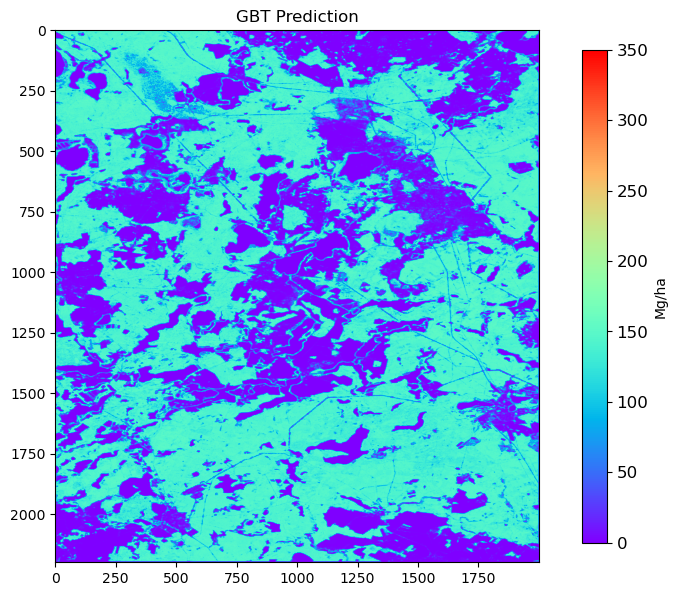

(array([112.87477, 140.27318, 148.13832, ..., 133.63475, -14.11016,
        145.14056], dtype=float32),
 93.62886905670166,
 28.031887,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.83167726>)

In [ ]:
# n_estimators = [50, 125, 200]
# max_tree_depths = [10, 15, 30]

# if EXPERIMENT_RUN == 'all':
#     gbt_output = m.parameter_experiments(n_estimators, max_tree_depths, 1, 'gbt', de_X_train, de_y_train, de_X_test, 
#                                 de_y_test, de_X_2d, de_height, de_width)

#     with open('data/output/de.txt', 'a') as file:
#         file.write('GBT Parameter Experiments Output:\n')
#         file.write(str(gbt_output))
#         file.write('\n\n')
    
#     del gbt_output

m.gbt(de_X_train, de_y_train, de_X_test, 
                                de_y_test, de_X_2d, de_height, de_width)

##### Input data experiments

In [ ]:
if EXPERIMENT_RUN != 'all':
    input_experiment_output_gbt = m.parameter_experiments([50], [15], NUM_SIMULATIONS, 'gbt', de_X_train, de_y_train, de_X_test, 
                                de_y_test, de_X_2d, de_height, de_width)

    with open('data/output/de.txt', 'a') as file:
        file.write('GBT Input Data Experiments Output (%s):\n' % EXPERIMENT_RUN)
        file.write(str(input_experiment_output_gbt))
        file.write('\n\n')

### CNNs

In [20]:
_, cnn_runtime, cnn_rmse, cnn_r2 = m.cnn(de_cnn_X_train, de_cnn_y_train, de_cnn_X_test, de_cnn_y_test, output=True, patch_size=200, original_shape=all_target_patches.shape[-1])

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 200, 200, 16)   │         2,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 100, 100, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 100, 100, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 200, 200, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 200, 200, 1)    │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,961 (27.19 KB)

 Trainable params: 6,961 (27.19 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step - loss: 12152.3350 - r2_score: 0.0231 - root_mean_squared_error: 110.2288 - val_loss: 11738.3867 - val_r2_score: 0.1960 - val_root_mean_squared_error: 108.3438
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - loss: 12211.0039 - r2_score: 0.1725 - root_mean_squared_error: 110.5020 - val_loss: 11638.6006 - val_r2_score: 0.1306 - val_root_mean_squared_error: 107.8823
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 12261.5703 - r2_score: 0.0876 - root_mean_squared_error: 110.7305 - val_loss: 11478.3643 - val_r2_score: 0.1127 - val_root_mean_squared_error: 107.1371
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - loss: 12014.2920 - r2_score: 0.0752 - root_mean_squared_error: 109.6097 - val_loss: 11224.1709 - val_r2_score: 0.0944 - val_root_mean_squared_error: 105.9442
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step - loss: 11671.9844 - r2_score: 0.0555 - root_mean_squared_error: 108.0365 - val_loss: 10833.5938 - val_r2_score: 0.0924 - va